# SIFT keypoint detector

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage as ndi

def build_octave(img_base, num_levels, sigma):
    '''Build the levels for one octave of the pyramid. img_base is the first image
       of the octave, num_levels the number of levels in the octave and sigma the
       blurring of the first image.'''
    
    num_intervals = num_levels - 1
    k = np.power(2, 1/num_intervals)
    octave_levels = np.zeros((num_intervals+3, img_base.shape[0], img_base.shape[1]))
    octave_levels[0] = img_base
    
    # Calculating sigma values
    sigma_inc = [sigma]
    # If we have an image I that was blurred with a value of sigma equal to sigma_prev 
    # and want to obtain an image blurred with sigma_next, we need to blur image I with the following sigma:
    # sig = sqrt(sigma_next**2 - sigma_prev**2)
    for i in range(1, num_intervals+3):
        sigma_prev = np.power(k, i-1)*sigma
        sigma_next = k*sigma_prev
        sig = np.sqrt(sigma_next**2 - sigma_prev**2)
        sigma_inc.append(sig)
    
    for i in range(1, num_intervals+3):
        blurred_img = ndi.gaussian_filter(octave_levels[i-1], sigma=sigma_inc[i])
        octave_levels[i] = blurred_img
        
    return octave_levels

def build_gauss_pyr(img, num_octaves, num_levels_per_octave=4, sigma=1.6):
    '''Build SIFT Gaussian pyramid'''
    
    # Assume input image has a blur of sigma=0.5, upsample and blur so that initial image
    # of the pyramid has a blur of sigma=1.6
    img_interp = ndi.zoom(img, 2, order=1)
    sig = np.sqrt(sigma**2 - 1) 
    initial_img = ndi.gaussian_filter(img_interp, sigma=sig)     
    
    gauss_pyr = []
    for i in range(num_octaves):
        if i==0:
            img_base = initial_img
        else:
            last_level = gauss_pyr[i-1][-3]   # Initial image for next level is 2 from the top
            img_base = last_level[::2, ::2]
            
        octave_levels = build_octave(img_base, num_levels_per_octave, sigma)
        gauss_pyr.append(octave_levels)
        
    return gauss_pyr

def plot_gauss_pyr(gauss_pyr):
    '''Visualize SIFT Gaussian pyramid.'''
    
    num_octaves = len(gauss_pyr)
    num_levels_per_octave = len(gauss_pyr[0])-2
    
    first_figsize = 16
    sigma_base = sigma
    for i in range(num_octaves):
        figsize = first_figsize/1.3**i
        plt.figure(figsize=(figsize, figsize/3))
        for k in range(num_levels_per_octave):
            s = sigma_base*np.power(2, k/(num_levels_per_octave-1))
            plt.subplot(1, num_levels_per_octave, k+1)
            plt.imshow(gauss_pyr[i][k], 'gray')
            plt.title('Octave=%d\nlevel=%d\nscale=%.2f'%(i, k, s))
        sigma_base = s
        
def plot_dog_pyr(dog_pyr):
    '''Visualize SIFT difference of Gaussians pyramid.'''
    
    num_octaves = len(dog_pyr)
    num_levels_per_octave = len(dog_pyr[0])-1
    
    first_figsize = 16
    sigma_base = sigma
    for i in range(num_octaves):
        figsize = first_figsize/1.3**i
        plt.figure(figsize=(figsize, figsize/3))
        for k in range(num_levels_per_octave):
            s = sigma_base*np.power(2, k/(num_levels_per_octave-1))
            plt.subplot(1, num_levels_per_octave, k+1)
            plt.imshow(dog_pyr[i][k], 'gray')
            plt.title('Octave=%d\nlevel=%d\nscale=%.2f'%(i, k, s))
        sigma_base = s        

        
def build_dog_pyr(gauss_pyr):
    '''Build Difference of Gaussians pyramid'''
    
    num_octaves = len(gauss_pyr)
    dog_pyr = []
    for mat_octave in gauss_pyr:
        mat_diff = np.diff(mat_octave, axis=0)
        dog_pyr.append(mat_diff)
            
    return dog_pyr    
        
def find_extrema(dog_pyr):
    '''Find maxima and minima on each octave'''

    num_octaves = len(dog_pyr)

    candidate_keypoints = []
    for octv_ind, mat_octave in enumerate(dog_pyr):
        for scale_ind in range(1, mat_octave.shape[0]-1):
            for row in range(1, mat_octave.shape[1]-1):
                for col in range(1, mat_octave.shape[2]-1):
                    patch = mat_octave[scale_ind-1:scale_ind+2, row-1:row+2, col-1:col+2]
                    ref_val = patch[1,1,1]

                    is_maximum = True
                    for ind, val in enumerate(patch.flatten()):
                        if ref_val<=val and ind!=13:
                            is_maximum = False
                            break

                    if is_maximum:
                        is_minimum = False
                    else:
                        is_minimum = True
                        for ind, val in enumerate(patch.flatten()):
                            if ref_val>=val and ind!=13:
                                is_minimum = False
                                break

                    if is_maximum or is_minimum:
                        candidate_keypoints.append((octv_ind, scale_ind, row, col))

    return candidate_keypoints 

def get_gradient(patch):
    '''Calculate the gradient using second order finite differences'''
    
    ds = (patch[2,1,1]-patch[0,1,1])/2
    dy = (patch[1,2,1]-patch[1,0,1])/2
    dx = (patch[1,1,2]-patch[1,1,0])/2

    g_patch = np.array([ds, dy, dx])
    return g_patch

def get_3d_hessian(patch):
    '''Calculate a 3D hessian matrix using finite differences'''
    
    dss = patch[2,1,1]+patch[0,1,1]-2*patch[1,1,1]
    dyy = patch[1,2,1]+patch[1,0,1]-2*patch[1,1,1]
    dxx = patch[1,1,2]+patch[1,1,0]-2*patch[1,1,1]
    dsy = (patch[2,2,1]-patch[2,0,1]-patch[0,2,1]+patch[0,0,1])/4
    dsx = (patch[2,1,2]-patch[2,1,0]-patch[0,1,2]+patch[0,1,0])/4
    dyx = (patch[1,2,2]-patch[1,0,2]-patch[1,2,0]+patch[1,0,0])/4
    
    H_patch = np.array([[dss, dsy, dsx],
                  [dsy, dyy, dyx],
                  [dsx, dyx, dxx]])   
    
    return H_patch

def get_2d_hessian(patch):
    '''Calculate a 2D hessian matrix using finite differences'''
    
    dyy = patch[2,1]+patch[0,1]-2*patch[1,1]
    dxx = patch[1,2]+patch[1,0]-2*patch[1,1]
    dyx = (patch[2,2]-patch[0,2]-patch[2,0]+patch[0,0])/4
    
    H_patch = np.array([[dyy, dyx],
                        [dyx, dxx]])   
    
    return H_patch

def accurate_kpt_location(kpt, dog_pyr, max_interp_steps=1, min_saliency=0.03):
    '''Fit a quadratic function at the keypoint and get the maximum. Used for
       a more accurate keypoint localization. Warning, unstable for max_interp_steps>1'''
    
    kpt = list(kpt)
    
    keep_going = True
    step_count = 0
    while keep_going and step_count<max_interp_steps:
       
        patch = dog_pyr[kpt[0]][kpt[1]-1:kpt[1]+2, kpt[2]-1:kpt[2]+2, kpt[3]-1:kpt[3]+2]
        g_patch = get_gradient(patch)
        H_patch = get_3d_hessian(patch)

        H_patch_inv = np.linalg.inv(H_patch)
        desl = -np.dot(H_patch_inv, g_patch)
        prec_kpt = kpt[1:] + desl                          # Position of the maximum
        saliency = patch[1,1,1] + np.sum(g_patch*desl)/2   # Value at the maximum
        if abs(saliency)<min_saliency:
            return None
        
        # Verify if we should fit the quadratic function at another pisition of the DoG pyramid
        prec_kpt_int = np.int_(np.round(prec_kpt))
        keep_going = False
        for ind, val in enumerate(desl):
            if val>=0.5 and prec_kpt_int[ind]<dog_pyr[kpt[0]].shape[ind]-1:
                kpt[ind+1] = prec_kpt[ind]
                keep_going = True
            elif val<=-0.5 and prec_kpt_int[ind]>0:
                kpt[ind+1] = prec_kpt[ind]
                keep_going = True
               
        step_count += 1
    
    return kpt

def interpolate_keypoints(candidate_keypoints, dog_pyr, min_saliency=0.03):
    '''Obtain a more accurate position of the keypoint.'''
    
    accurate_kpts = []
    for kpt in candidate_keypoints:
        octave_ind, level_ind, row, col = kpt
        new_kpt = accurate_kpt_location(kpt, dog_pyr, min_saliency)
        if new_kpt is not None:
            accurate_kpts.append(new_kpt)
            
    return accurate_kpts

def remove_edge_keypoints(candidate_keypoints, dog_pyr, max_edgeness=10):
    '''Remove keypoints having strong response to edges.'''
    
    new_kpts = []
    for kpt in candidate_keypoints:
        kpt_int = np.int_(np.round(kpt))
        patch = dog_pyr[kpt_int[0]][kpt_int[1], kpt_int[2]-1:kpt_int[2]+2, kpt_int[3]-1:kpt_int[3]+2]       
        H_patch = get_2d_hessian(patch)    
        saliency = (H_patch[0,0]+H_patch[1,1])**2/(H_patch[0,0]*H_patch[1,1]-H_patch[0,1]**2)
        if saliency<max_edgeness:
            new_kpts.append(kpt)
            
    return new_kpts

def draw_keypoints(kpts, img, min_octave=1):
    '''Draw keypoints in an image.'''
    
    kpt_coords = []
    for kpt in kpts:
        if kpt[0]>=min_octave:
            factor = 2**(int(kpt[0])-1)
            s = 4*factor*np.power(2, kpt[1]/(num_levels_per_octave-1))

            row, col = round(kpt[2]), round(kpt[3])
            row, col = factor*row, factor*col
            kpt_coords.append((s, int(row), int(col)))


    img_keys = (255*img).astype(np.uint8)
    for kpt in kpt_coords:
        s, row, col = int(kpt[0]), int(kpt[1]), int(kpt[2])
        cv2.circle(img_keys, (col, row), s, 255, 1)
    
    return img_keys



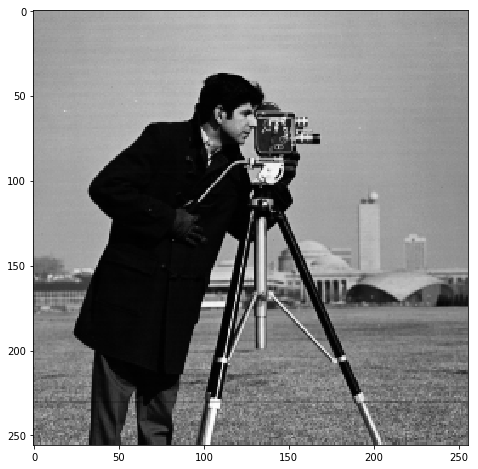

In [2]:
img = cv2.imread('cameraman.tiff', 0)
img = (img-np.min(img))/(np.max(img)-np.min(img))

plt.figure(figsize=[8,8])
plt.imshow(img, 'gray')

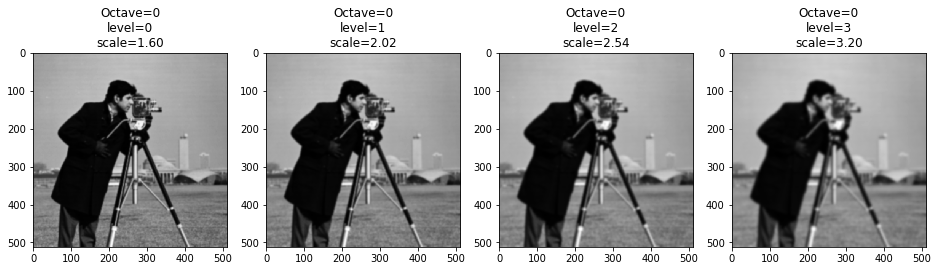

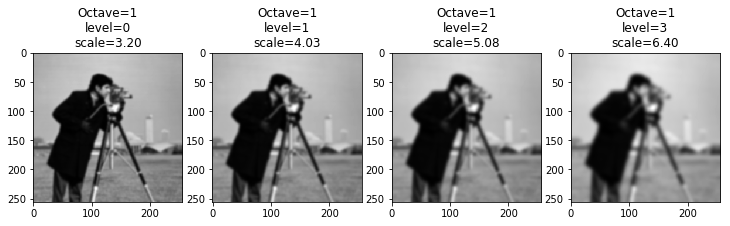

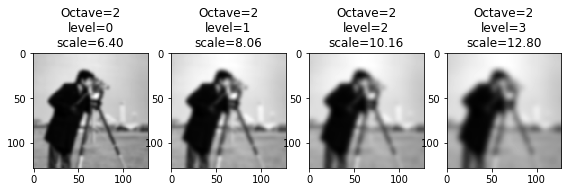

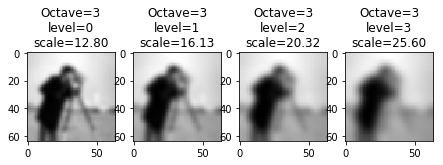

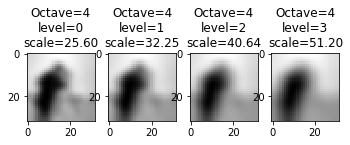

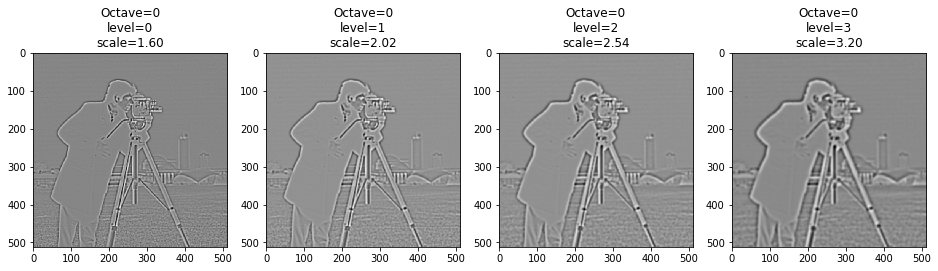

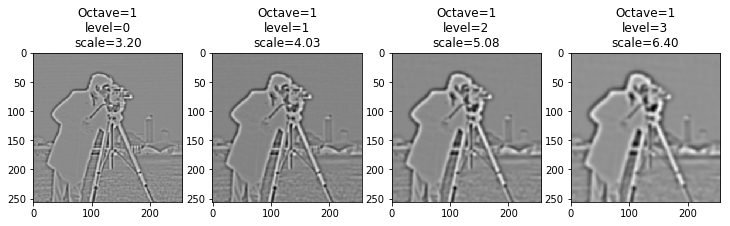

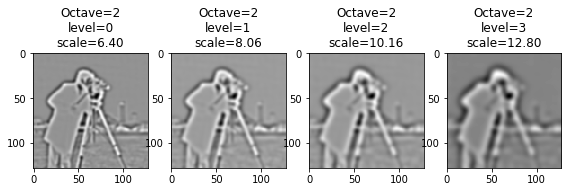

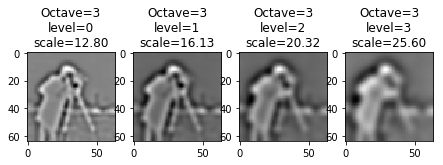

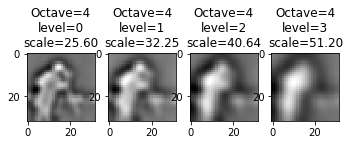

In [3]:
num_octaves = int(np.log2(min(img.shape))-5)+2    # Number of octaves so that smallest image has size 2**5=32
sigma = 1.6                                         # Best sigma according to Lowe
num_levels_per_octave = 4                           # Best number of suboctaves according to Lowe

gauss_pyr = build_gauss_pyr(img, num_octaves=num_octaves, num_levels_per_octave=num_levels_per_octave, sigma=sigma)
dog_pyr = build_dog_pyr(gauss_pyr)

plot_gauss_pyr(gauss_pyr)
plot_dog_pyr(dog_pyr)
    

        

In [4]:
candidate_keypoints = find_extrema(dog_pyr)
accurate_kpts = interpolate_keypoints(candidate_keypoints, dog_pyr, 
                                      min_saliency=0.1)
final_kpts = remove_edge_keypoints(accurate_kpts, dog_pyr, 
                                   max_edgeness=10)

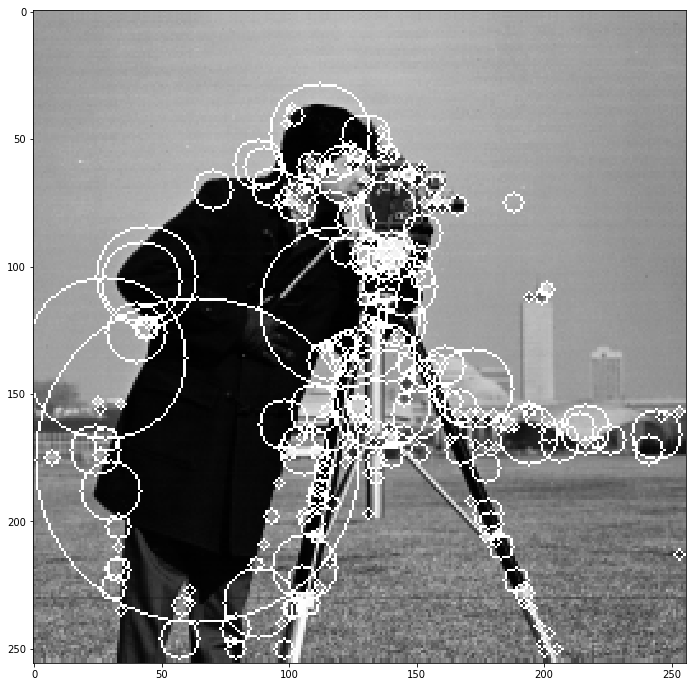

In [5]:
img_keys = draw_keypoints(final_kpts, img, 0)
    
plt.figure(figsize=[12,12])
plt.imshow(img_keys, 'gray')